# Where to Focus - Item Comparisons

### Introduction

In this lesson, we'll learn about item comparisons.

Item comparison occurs when we are comparing numbers or percentages between categories.  Sometimes these numbers are percentages:

* "Chocolate ice cream accounted for 25 percent of sales."

And sometimes these are the baseline numbers

* "Chocolate ice cream accounted for $25 mil in sales."

> Item comparisons almost always involve grouping.  So be careful to choose the correct units when performing that grouping.  So if we chose regional sales -- remember that this may not mean one region is performing better than another -- that region may just have more stores.

The point of focusing on item comparisons is that they are an initial way to determine what to focus on.  If there is a category that accounts for a large amount of sales (or a surprisingly small amount), it is likely worth our attention.

### Exploring our data

In this lesson, we'll learn about item comparisons by using our ecommerce sales data.  Let's get started.  

In [1]:
import pandas as pd
df = pd.read_csv('./sales_data.csv', index_col = 0)
df[:2]

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales,City,Hour
0,295665,Macbook Pro Laptop,1,1700.0,2019-12-30 00:01:00,"136 Church St, New York City, NY 10001",12,1700.0,New York City,0
1,295666,LG Washing Machine,1,600.0,2019-12-29 07:03:00,"562 2nd St, New York City, NY 10001",12,600.0,New York City,7


Ok, so once our data is clean, performing an item comparison is a good initial step. To do  can use a group by (whether in pandas or SQL).

For example, we can check our total product sales by price with something like the following.

In [2]:
top_products = df.groupby(['Product'])['Price Each'].agg(['sum']).sort_values('sum', ascending = False)
top_products[:3]

,sum
Product,
Macbook Pro Laptop,8030800.00
iPhone,4789400.00
ThinkPad Laptop,4127958.72


And we can even turn this into a function.

In [3]:
def build_grouped_by(df, col, target, agg = 'sum', agg_name = None, pct = True):
    grouped_data = df.groupby(col)[target].agg([agg]).sort_values(agg, ascending = False)
    if pct:
        grouped_data = (grouped_data/df[target].sum()).round(3)
    if agg_name:
        grouped_data = grouped_data.rename(columns={agg: agg_name})
    return grouped_data

So then if we want to break down our data across different dimensions we can -- below we group by both city and hour.

In [6]:
target = 'Price Each'
grouped_data = build_grouped_by(df, 'City', target, agg = 'sum', agg_name = 'percent_revenue')
grouped_data

,percent_revenue
City,
San Francisco,0.239
Los Angeles,0.158
New York City,0.135
Boston,0.106
Atlanta,0.081
Dallas,0.080
Seattle,0.080
Portland,0.067
Austin,0.053


In [7]:
cols = ['City', 'Hour']
target = 'Price Each'
totals_by_col = [build_grouped_by(df, col, target, agg = 'sum', agg_name = 'total_revenue') for col in cols]

totals = dict(zip(cols, totals_by_col))

And now we can see the percentage sales by city.

In [8]:
totals['City'][:3]

,total_revenue
City,
San Francisco,0.239
Los Angeles,0.158
New York City,0.135


### Viewing our data

Now that we have grouped our data, it can be a little easier to see the message by plotting the data.  Below, we wrote a print grouped by function.

In [15]:
import matplotlib.pyplot as plt
def print_grouped_by(grouped, title = "", axis = '', limit = 10, y_range = [0, 1]):
    selected_group = grouped[grouped.iloc[:, 0].values != None]
    fig = plt.figure(figsize=(14, 2))
    
    plt.scatter(selected_group.index[:limit], selected_group.iloc[:limit, 0])
    plt.ylim(y_range)
    plt.title(title)
    plt.show()

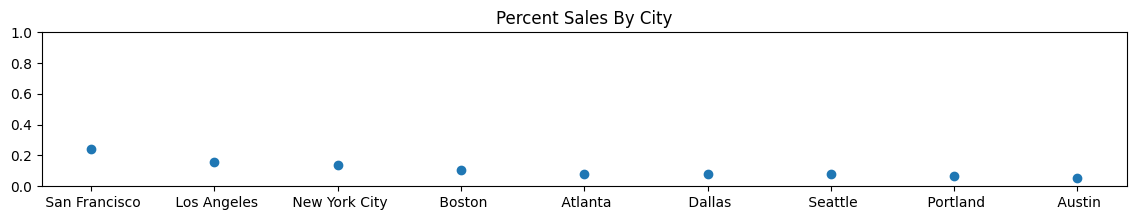

In [14]:
# print_grouped_by()
grouped = totals['City']
print_grouped_by(grouped, title = "Percent Sales By City")

Let's quickly break down our function above.  It uses matplotlib to print the data.  And the first step, `selected_group` removes any values that are None.  Then we create a figure (essentially our canvas).  And after that create a scatter plot where we have our x values be the index (in this case the city), and the y values be the first column.  We limit to the first 10 values.

### All together now

Ok, so then a quick way to determine what to focus on is create grouped bys out of a series of columns.

In [200]:
df.columns

Index(['Order ID', 'Product', 'Quantity Ordered', 'Price Each', 'Order Date',
       'Purchase Address', 'Month', 'Sales', 'City', 'Hour'],
      dtype='object')

> These columns look good.

In [201]:
grouped_by_cols = ['Product', 'City', 'Month', 'Hour', 'Purchase Address']

Let's take our above code and wrap it in a function.

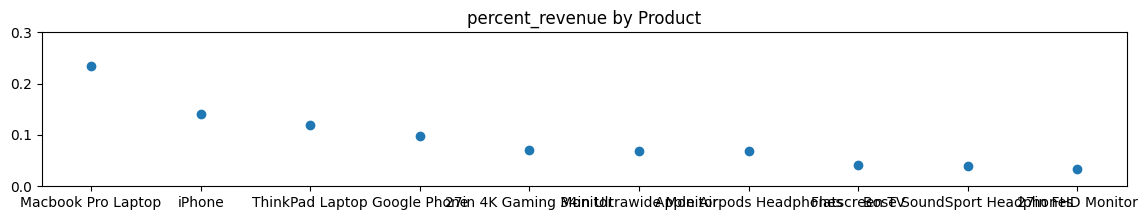

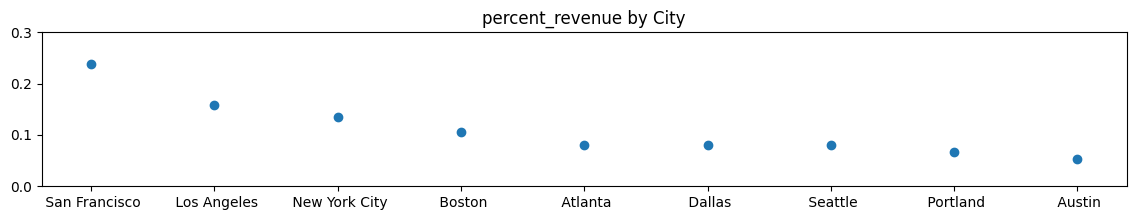

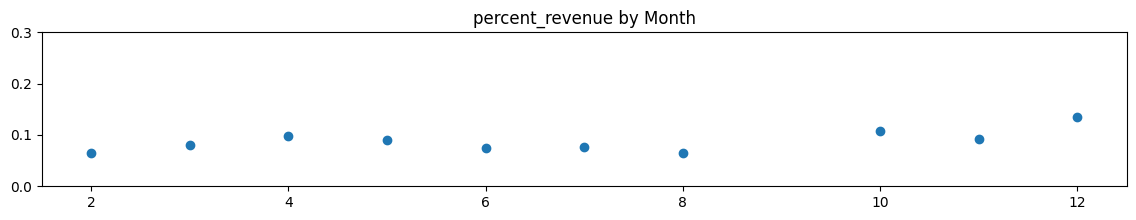

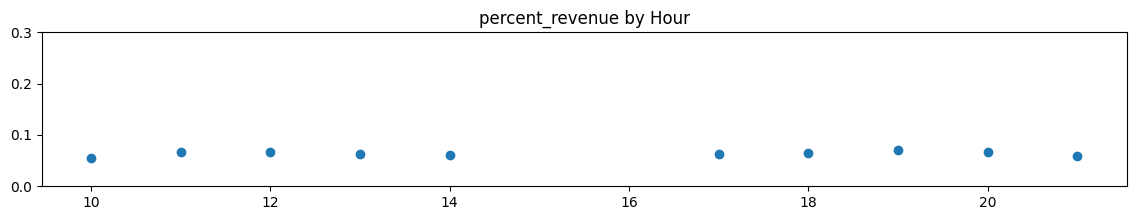

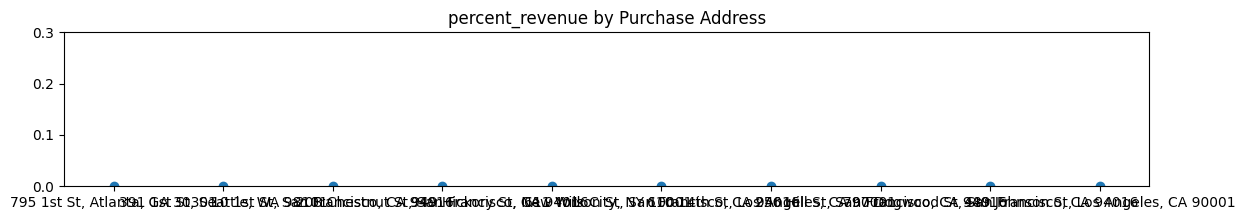

In [22]:
def build_and_print(df, cols, target, agg = 'sum', agg_name = "", y_range = [0, 1]):
    totals_by_col = [build_grouped_by(df, col, target, agg = 'sum', agg_name = agg_name)
                 for col in cols]
    totals = dict(zip(cols, totals_by_col))
    [print_grouped_by(df, title = f"{agg_name} by {col}", y_range = y_range) for col, df in totals.items()]
    return totals

# call function
target = 'Price Each'
agg_name = 'percent_revenue'
cols = ['Product', 'City', 'Month', 'Hour', 'Purchase Address']

results = build_and_print(df, cols, target, agg = 'sum', agg_name = agg_name, y_range = [0, .3])

So from here, we can dig deeper on a few categories in our dataset.  For example, notice that the top five products account for about 60 percent of our revenue. 

The return value of our function call above is a dictionary of our results.  So we can look deeper at that with the following.

In [204]:
results.keys() # dict_keys(['Product', 'City', 'Month', 'Hour', 'Purchase Address'])
results['Product'][:5]

,percent_revenue
Product,
Macbook Pro Laptop,0.234
iPhone,0.140
ThinkPad Laptop,0.120
Google Phone,0.097
27in 4K Gaming Monitor,0.071


### Multiple Dimensions

Once we have identified a couple of the key categories -- we may want to look a little deeper at those categories.  We can do this with a multilevel group by.  So below, we group by two categories and calculate the percentage of total revenue -- and we can do this by just passing through a list of columns to group by instead of a single column.

In [205]:
pd.set_option('display.max_rows', None)
multiple_groups = build_grouped_by(df, ['Product', 'City'], target, agg = 'sum', agg_name = 'percent_revenue')

> This works because the groupby function can take multiple columns.

```python
       # can take multiple cols
grouped_data = df.groupby(col)[target].agg([agg]).sort_values(agg, ascending = False)
```

Ok, let's look at the results.

In [206]:
multiple_groups[:15]

percent_revenue
Product                City                           
Macbook Pro Laptop      San Francisco            0.056
                        Los Angeles              0.037
iPhone                  San Francisco            0.034
Macbook Pro Laptop      New York City            0.033
ThinkPad Laptop         San Francisco            0.028
Google Phone            San Francisco            0.024
Macbook Pro Laptop      Boston                   0.024
iPhone                  Los Angeles              0.023
Macbook Pro Laptop      Dallas                   0.019
                        Atlanta                  0.019
ThinkPad Laptop         Los Angeles              0.019
iPhone                  New York City            0.018
Macbook Pro Laptop      Seattle                  0.018
                        Portland                 0.017
27in 4K Gaming Monitor  San Francisco            0.017

So this is not a bad way to look at the data.  Our groupings are sorted by percent revenue, and we can look for anything that stands out.  For example, considering that Seattle and Portland have a relatively low percentage of sales, it's interesting to see them on our list (with the Macbook Pro Laptop).  It seems like demand for these products is particularly strong.

* Pivot tables 

One way to look at more information is to turn the data into a grid with a pivot table.  Below we pass our multiaggregated dataframe into the `pd.pivot_table` function, and specify the index and the columns.

In [207]:
pivot = pd.pivot_table(multiple_groups, index=['Product'], columns=['City'])
pivot[:2]

percent_revenue                                       \
City                           Atlanta  Austin  Boston  Dallas  Los Angeles   
Product                                                                       
20in Monitor                     0.001   0.001   0.001   0.001        0.002   
27in 4K Gaming Monitor           0.006   0.004   0.008   0.005        0.011   

                                                                         
City                    New York City  Portland  San Francisco  Seattle  
Product                                                                  
20in Monitor                    0.002     0.001          0.003    0.001  
27in 4K Gaming Monitor          0.010     0.005          0.017    0.006

And next, let's try to organize our data.  Let's reorder the index (our rows) with our top ranking to lowest ranking products.

In [208]:
sorted_products_pivot = pivot.loc[results['Product'].index]

sorted_products_pivot[:2]

percent_revenue                                       \
City                       Atlanta  Austin  Boston  Dallas  Los Angeles   
Product                                                                   
Macbook Pro Laptop           0.019   0.012   0.024   0.019        0.037   
iPhone                       0.011   0.008   0.015   0.011        0.023   

                                                                     
City                New York City  Portland  San Francisco  Seattle  
Product                                                              
Macbook Pro Laptop          0.033     0.017          0.056    0.018  
iPhone                      0.018     0.009          0.034    0.011

And next let's reorder the columns.  This is a little tricker.  The problem is that our columns are actually multileveled.

In [209]:
sorted_products_pivot.columns[:3]

MultiIndex([('percent_revenue', ' Atlanta'),
            ('percent_revenue',  ' Austin'),
            ('percent_revenue',  ' Boston')],
           names=[None, 'City'])

So let's change this by getitng the second level of columns (the city names), and then resetting our column names.

In [210]:
leveled_cols = sorted_products_pivot.columns.get_level_values(1)
sorted_products_pivot.columns = leveled_cols

In [211]:
sorted_products_pivot[:3]

City,Atlanta,Austin,Boston,Dallas,Los Angeles,New York City,Portland,San Francisco,Seattle
Product,,,,,,,,,
Macbook Pro Laptop,0.019,0.012,0.024,0.019,0.037,0.033,0.017,0.056,0.018
iPhone,0.011,0.008,0.015,0.011,0.023,0.018,0.009,0.034,0.011
ThinkPad Laptop,0.010,0.006,0.013,0.010,0.019,0.016,0.008,0.028,0.010


Now that our column names are back to city names, we can reorder the columns to be the order of our top cities.  So let's get the order of our top cities, which we calculated before.

In [212]:
city_cols = results['City'].index
city_cols

Index([' San Francisco', ' Los Angeles', ' New York City', ' Boston',
       ' Atlanta', ' Dallas', ' Seattle', ' Portland', ' Austin'],
      dtype='object', name='City')

And then reindex our columns.

In [214]:

ordered_pivot = sorted_products_pivot.reindex(columns=city_cols)
ordered_pivot[:10]

City,San Francisco,Los Angeles,New York City,Boston,Atlanta,Dallas,Seattle,Portland,Austin
Product,,,,,,,,,
Macbook Pro Laptop,0.056,0.037,0.033,0.024,0.019,0.019,0.018,0.017,0.012
iPhone,0.034,0.023,0.018,0.015,0.011,0.011,0.011,0.009,0.008
ThinkPad Laptop,0.028,0.019,0.016,0.013,0.010,0.010,0.010,0.008,0.006
Google Phone,0.024,0.015,0.013,0.010,0.008,0.008,0.008,0.006,0.005
27in 4K Gaming Monitor,0.017,0.011,0.010,0.008,0.006,0.005,0.006,0.005,0.004
34in Ultrawide Monitor,0.016,0.011,0.010,0.007,0.005,0.006,0.006,0.004,0.004
Apple Airpods Headphones,0.016,0.011,0.009,0.007,0.006,0.005,0.005,0.005,0.004
Flatscreen TV,0.010,0.006,0.005,0.005,0.004,0.004,0.003,0.003,0.002
Bose SoundSport Headphones,0.010,0.006,0.005,0.004,0.003,0.003,0.003,0.003,0.002


Essentially, we are looking to see if there is anything unexpected.  If everything is as expected, then the numbers should be high to low both going from left to right through each row.  And going from top to bottom through each column.

A heatmap, may make this a bit easier to see.

<AxesSubplot: xlabel='City', ylabel='Product'>

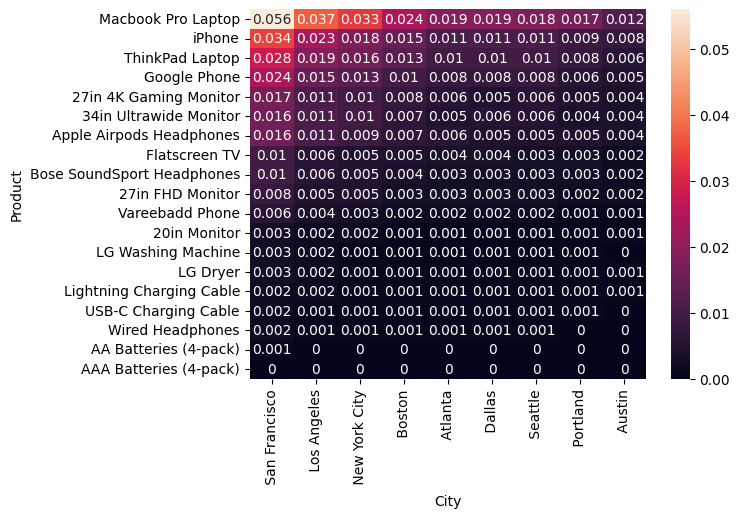

In [216]:
import seaborn as sns
sns.heatmap(ordered_pivot, annot=True)

So in this case everything is essentially as expected.  Although, we may want to look again at the Seattle and Portland macbook pro numbers that we saw before.

### Summary

In this lesson, we saw some quick ways to view our data.

In [ ]:
def build_grouped_by(df, col, target, agg = 'sum', agg_name = None, pct = True):
    grouped_data = df.groupby(col)[target].agg([agg]).sort_values(agg, ascending = False)
    if pct:
        grouped_data = (grouped_data/df[target].sum()).round(3)
    if agg_name:
        grouped_data = grouped_data.rename(columns={agg: agg_name})
    return grouped_data

In [ ]:
import matplotlib.pyplot as plt
def print_grouped_by(grouped, title = "", axis = '', limit = 10):
    selected_group = grouped[grouped.iloc[:, 0].values != None]
    fig = plt.figure(figsize=(14, 2))
    plt.scatter(selected_group.index[:limit], selected_group.iloc[:limit, 0])
    plt.title(title)
    plt.show()

In [221]:
def build_and_print(df, cols, target, agg = 'sum', agg_name = agg_name):
    totals_by_col = [build_grouped_by(df, col, target, agg = 'sum', agg_name = agg_name)
                 for col in cols]
    totals = dict(zip(cols, totals_by_col))
    [print_grouped_by(df, title = f"{agg_name} by {col}") for col, df in totals.items()]
    return totals


target = 'Price Each'
agg_name = 'percent_revenue'
cols = ['Product', 'City', 'Month', 'Hour', 'Purchase Address']

# results = build_and_print(df, cols, target, agg = 'sum', agg_name = agg_name)

* Digging Deeper 

Then we saw how we can analyze a dataset across multiple dimensions.

We did this by just passing through a list of columns into our `build_grouped_by`.

In [220]:
# multiple_groups = build_grouped_by(df, ['Product', 'City'], target, agg = 'sum', agg_name = 'percent_revenue')

And then we worked on ordering both the rows and columns -- and we did so using the results of our previous aggregations.

> First organizing the rows by re-indexing.

In [ ]:
sorted_products_pivot = pivot.loc[results['Product'].index]

> And then organizing the columns, by flattening our column values.

In [ ]:
leveled_cols = sorted_products_pivot.columns.get_level_values(1)
sorted_products_pivot.columns = leveled_cols

> And then reindexing.

In [ ]:
city_cols = results['City'].index
ordered_pivot = sorted_products_pivot.reindex(columns=city_cols)

### Bonus: An alternative group by 

We can use the following function if our data is in SQL.

In [ ]:
def build_grouped_by(table_name, col, target, engine, order_by_col = False):
    if order_by_col:
        query = f"""select {col}, sum({target}) total_amount from {table_name} group by {col} order by {col} asc"""
    else:
        query = f"""select {col}, sum({target}) total_amount from {table_name} group by {col} order by total_amount desc"""
    grouped = pd.read_sql(query, engine)
    return grouped

In [ ]:
pivot = pd.pivot_table(multiple_groups, index=['Product'], columns=['City'])
pivot[:2]

In [ ]:
sorted_products_pivot = pivot.loc[results['Product'].index]

sorted_products_pivot[:2]

### Resources

[Sales Product Data](https://www.kaggle.com/datasets/knightbearr/sales-product-data)

[Unit Economics](https://www.paddle.com/resources/unit-economics)

[Olist Dataset Multitables](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce)
